# dlibを使った顔の位置・部位の検出と瞳位置の検出方法の策定

In [1]:
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.gray()

<Figure size 432x288 with 0 Axes>

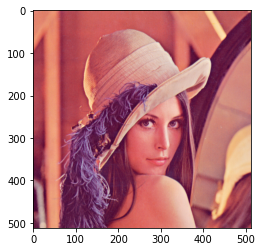

In [2]:
img_cv2 = cv2.imread('data/lena.png', cv2.IMREAD_COLOR)
height, width = img_cv2.shape[:2]
img_RGB = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
plt.imshow(img_RGB)

## 顔の位置の検出

In [3]:
detector = dlib.get_frontal_face_detector()
CUT_OFF = -0.1
rects, scores, types = detector.run(img_cv2, 1, CUT_OFF)

In [4]:
print('------rects------')
print(rects)
print('------scores------')
print(scores)
print('------types------')
print(types)


------rects------
rectangles[[(218, 219) (373, 374)]]
------scores------
[0.9606970344683554]
------types------
[2]


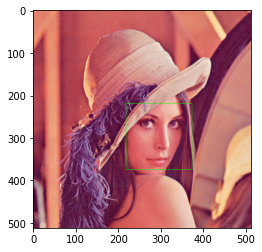

In [5]:
tmp_img = img_cv2.copy()
for i, rect in enumerate(rects):
    top, bottom, left, right = rect.top(), rect.bottom(), rect.left(), rect.right()
    cv2.rectangle(tmp_img, (left, top), (right, bottom), (0, 255, 0))

tmp_img_RGB = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
plt.imshow(tmp_img_RGB)

## 顔の部位（landmark）の検出

In [6]:
# dlibの座標の出力形式を(x, y)のタプルに変換する
def part_to_coordinates(part):
    return (part.x, part.y)

def shape_to_landmark(shape):
    landmark = []
    for i in range(shape.num_parts):
        landmark.append(part_to_coordinates(shape.part(i)))
    return landmark


True

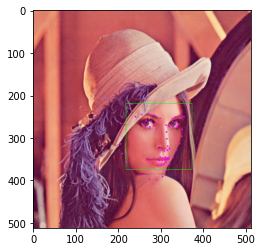

In [7]:
predictor = dlib.shape_predictor('./data/shape_predictor_68_face_landmarks.dat')
shape = predictor(img_cv2, rects[0])

# 検出したshapeをlandmark（座標のリスト）に変換
landmark = shape_to_landmark(shape)
for point in landmark:
    cv2.circle(tmp_img, point, 2, (255, 0, 255), thickness=-1)

tmp_img_RGB = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
plt.imshow(tmp_img_RGB)

cv2.imwrite('landmarks_image.png', tmp_img)

### 目の部分の切り出し

In [8]:
def cut_out_eye_img(img_cv2, eye_points):
    height, width = img_cv2.shape[:2]
    x_list = []; y_list = []
    for point in eye_points:
        x_list.append(point[0])
        y_list.append(point[1])
    x_min = max(min(x_list) - 3, 0)
    x_max = min(max(x_list) + 4, width)
    y_min = max(min(y_list) - 3, 0)
    y_max = min(max(y_list) + 4, height)
    eye_img = img_cv2[y_min : y_max, x_min : x_max]
    return eye_img, x_min, x_max, y_min, y_max

True

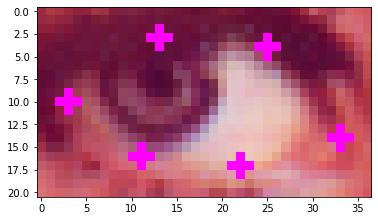

In [9]:
eye_img, x_min, x_max, y_min, y_max = cut_out_eye_img(img_cv2, landmark[36:42])

# 表示確認
eye_img_copy = eye_img.copy()
landmark_local = []
for point in landmark[36:42]:
    point_local = (point[0] - x_min, point[1] - y_min)
    landmark_local.append(point_local)
    cv2.circle(eye_img_copy, point_local, 1, (255, 0, 255), thickness=-1)

tmp_img_RGB = cv2.cvtColor(eye_img_copy, cv2.COLOR_BGR2RGB)
plt.imshow(tmp_img_RGB)
cv2.imwrite('eye_image.png', eye_img_copy)

### 瞳位置の検出（１）　矩形の列ごとの和を単純比較

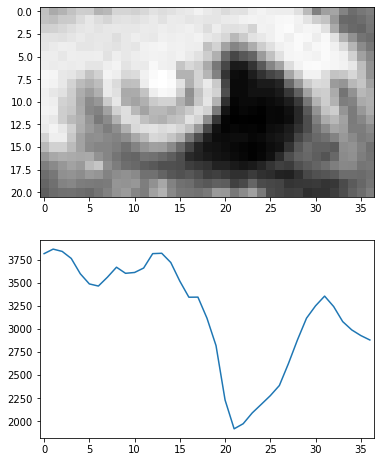

In [10]:
# グレースケース化
eye_img_gray = cv2.cvtColor(eye_img, cv2.COLOR_BGR2GRAY)

# ポジ→ネガ反転
eye_img_negative = 255 - eye_img_gray
# plt.imshow(eye_img_negative)
eye_img_gray.shape

# 列ごとに縦方向の和を求める
sum_x = np.sum(eye_img_negative, axis=0)

# グラフ化
fig = plt.figure(figsize=(6, 8))
plt.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(2, 1, 1) 
ax1.imshow(eye_img_negative)
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(sum_x)
ax2.set_xlim([-0.5, 36.5])

fig.show()
fig.savefig('./simple_sum.png')

瞳以外の列も高い値を示している。
目の領域外（まつ毛や瞼の影）の黒い部分が大きく影響している。  
　　↓  
目の領域だけを対象にすればいいのではないか？

### 瞳位置の検出（２）　目の部分を切り取る（列単位で比較）

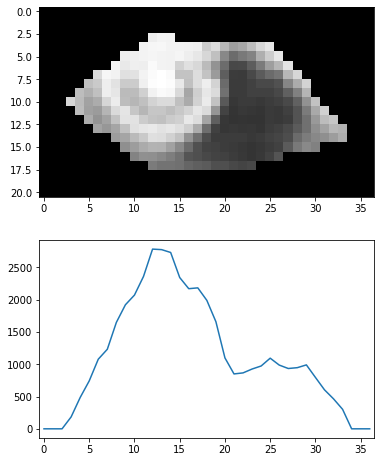

In [11]:
# グレースケース化
eye_img_gray = cv2.cvtColor(eye_img, cv2.COLOR_BGR2GRAY)

# ポジ→ネガ反転
eye_img_negative = 255 - eye_img_gray
eye_img_gray.shape

# 目の部分をマスク処理
eye_mask = np.zeros_like(eye_img_gray)
eye_mask = cv2.fillConvexPoly(eye_mask, np.array(landmark_local), True, 1)
eye_img_negative_masked = np.where(eye_mask == 1, eye_img_negative, 0)

# 列ごとに縦方向の和を求める
sum_x = np.sum(eye_img_negative_masked, axis=0)

# グラフ化
fig = plt.figure(figsize=(6, 8))
plt.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(2, 1, 1) 
ax1.imshow(eye_img_negative_masked)
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(sum_x)
ax2.set_xlim([-0.5, 36.5])

fig.show()
fig.savefig('./masked_sum.png')

### 移動平均
上記方法で、この画像はうまく瞳（虹彩）の位置を検出できたが、  
・結膜（白目）部分とと虹彩（黒目）部分がはっきりしている  
・虹彩と瞳孔（虹彩の中心の特に黒い部分）の差が大きい  
という瞳（瞳孔）の検出に有利な条件が揃っていたことが大きいと考えられる。  
よりロバスト（頑強）な検出方法を模索し、列単位で単純比較するのではなく、移動平均(moving average)を試してみる  

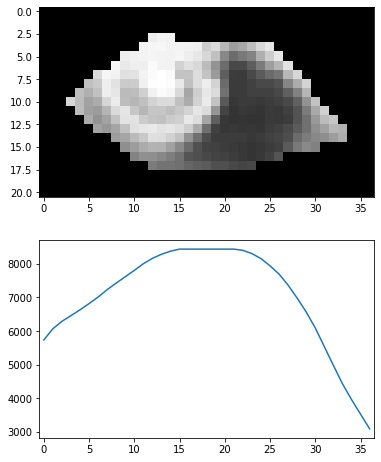

In [12]:
# 画像の大きさ
height, width = eye_img.shape[:2]

# グレースケース化
eye_img_gray = cv2.cvtColor(eye_img, cv2.COLOR_BGR2GRAY)

# ポジ→ネガ反転
eye_img_negative = 255 - eye_img_gray
eye_img_gray.shape

# 目の部分をマスク処理
eye_mask = np.zeros_like(eye_img_gray)
eye_mask = cv2.fillConvexPoly(eye_mask, np.array(landmark_local), True, 1)
eye_img_negative_masked = np.where(eye_mask == 1, eye_img_negative, 0)

# 列ごとに縦方向の和を求める
sum_x = np.sum(eye_img_negative_masked, axis=0)

# 移動平均を求める
n = 5
v = np.full(width, 1/n)
moving_ave = np.convolve(sum_x, v, mode='same')

# グラフ化
fig = plt.figure(figsize=(6, 8))
plt.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(2, 1, 1) 
ax1.imshow(eye_img_negative_masked)
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(moving_ave)
ax2.set_xlim([-0.5, 36.5])

fig.show()
fig.savefig('./moving_ave.png')

### 重み付き移動平均
移動平均を用いることでよりロバストになったと思われるが、反面、どの列が瞳孔か判別できなくなってしまった。  
ロバスト性と分解能の両立を求め、重み付き移動平均(weighing moving average)を試す。

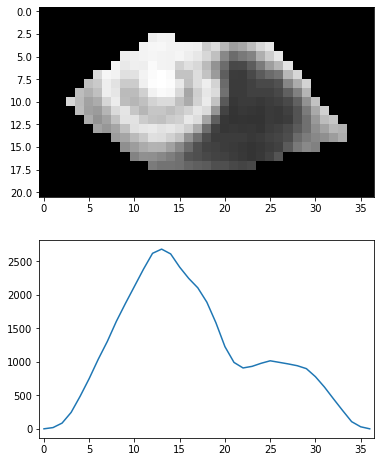

In [13]:
# 画像の大きさ
height, width = eye_img.shape[:2]

# グレースケース化
eye_img_gray = cv2.cvtColor(eye_img, cv2.COLOR_BGR2GRAY)

# ポジ→ネガ反転
eye_img_negative = 255 - eye_img_gray
eye_img_gray.shape

# 目の部分をマスク処理
eye_mask = np.zeros_like(eye_img_gray)
eye_mask = cv2.fillConvexPoly(eye_mask, np.array(landmark_local), True, 1)
eye_img_negative_masked = np.where(eye_mask == 1, eye_img_negative, 0)

# 列ごとに縦方向の和を求める
sum_x = np.sum(eye_img_negative_masked, axis=0)

# 重み付き移動平均を求める
v = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
weighing_moving_ave_x = np.convolve(sum_x, v, mode='same')

# グラフ化
fig = plt.figure(figsize=(6, 8))
plt.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(2, 1, 1) 
ax1.imshow(eye_img_negative_masked)
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(weighing_moving_ave_x)
ax2.set_xlim([-0.5, 36.5])

fig.show()
fig.savefig('./weighing_moving_ave_x.png')

重み付き平均を用いることで、格段に分解能が向上した。  
これでロバスト性と分解能が両立できているのではないかと考えられる。  
縦方向でも試してみる。

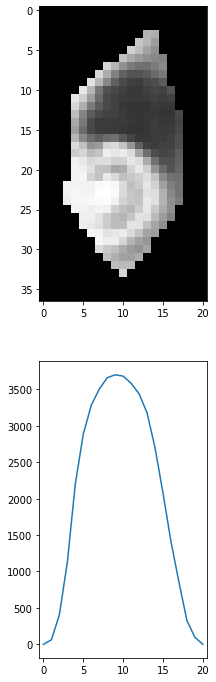

In [14]:
# 横方向の和を求める
sum_y = np.sum(eye_img_negative_masked, axis=1)

# 重み付き移動平均を求める
v = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
weighing_moving_ave_y = np.convolve(sum_y, v, mode='same')

# グラフ化
fig = plt.figure(figsize=(3, 12))
plt.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(2, 1, 1) 
ax1.imshow(cv2.rotate(eye_img_negative_masked, cv2.ROTATE_90_COUNTERCLOCKWISE))
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(weighing_moving_ave_y)
ax2.set_xlim([-0.5, 20.5])

fig.show()
fig.savefig('./weighing_moving_ave_y.png')

center : (13, 9)


True

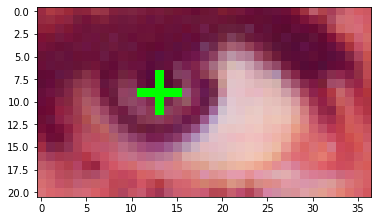

In [15]:
pupil_x = np.argmax(weighing_moving_ave_x)
pupil_y = np.argmax(weighing_moving_ave_y)
print(f'center : ({pupil_x}, {pupil_y})')

eye_img_copy = eye_img.copy()
cv2.line(eye_img_copy, (pupil_x - 2, pupil_y), (pupil_x + 2, pupil_y), (0, 255, 0))
cv2.line(eye_img_copy, (pupil_x, pupil_y - 2), (pupil_x, pupil_y + 2), (0, 255, 0))

tmp_img_RGB = cv2.cvtColor(eye_img_copy, cv2.COLOR_BGR2RGB)
plt.imshow(tmp_img_RGB)
cv2.imwrite('./detected_pupil.png', eye_img_copy)